In [ ]:
import torch
%matplotlib inline
from torchvision import datasets, transforms

In [72]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [73]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)
<class 'numpy.ndarray'>


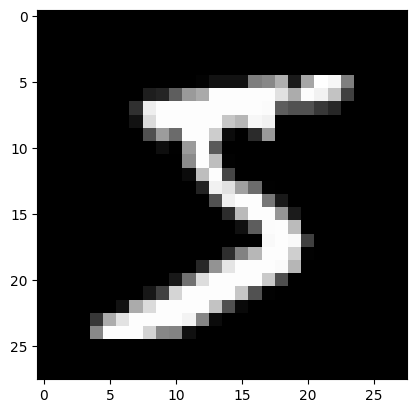

In [74]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)
print(type(x_train))


In [75]:
#将数据转换为tensor
x_train,y_train,x_valid,y_valid = map(
    torch.tensor,(x_train,y_train,x_valid,y_valid)
)

In [76]:
y_train[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [77]:
n,c = x_train.shape

In [78]:
import torch.nn.functional as F
loss_func = F.cross_entropy


* 全连接
* 输入层                 (batch,784)
* 隐藏层(128)            (batch,784)  $w_1$(784,128) $b_1$(128,) ->(batch,128)
* 隐藏层(64)            (batch,128)  $w_2$(128,64) $b_2$(64,) ->(batch,64)
* 输出层(10)(softmax)    (batch,64)  $w_3$(64,10) $b_2$(10,)  -> (batch,10)



In [79]:
from torch import nn
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(28*28,128)
        self.hidden2=nn.Linear(128,64)
        self.out=nn.Linear(64,10)
        self.dropout=nn.Dropout(0.3)

    def forward(self, x):
        #x (batch,784)
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x


In [80]:
net = FCN()
print(net)

FCN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


* $w和b都会自动生成 可以查看参数$

In [81]:
for name,parameter in net.named_parameters():
    #print(name,parameter,parameter.size())
    print(name)

hidden1.weight
hidden1.bias
hidden2.weight
hidden2.bias
out.weight
out.bias


In [82]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs=64

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [83]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [84]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """
    :param epochs: 轮次
    :param model: net
    :param loss_func: 损失函数
    :param opt: 优化器
    :param train_dl: x(64,784) y(64)
    :param valid_dl:
    :return:
    """
    for epoch in range(epochs):
        ##
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        ##
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(epoch), '验证集损失：'+str(val_loss))

In [85]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    1loss
    2更新w,b
    :param model: net
    :param loss_func: 损失函数
    :param xb:
    :param yb:
    :param opt: 优化器
    :return:
    """
    loss = loss_func(model(xb), yb)
    if opt is not None:
            loss.backward()
            #梯度存在每个参数的 .grad 属性里，优化器初始化时记住了所有参数的引用
            #optimizer.step() 时直接访问这些 .grad 来更新参数。
            opt.step()
            opt.zero_grad()
    return loss.item(),len(xb)

In [87]:
from torch import optim
opt = optim.Adam(net.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
fit(30, net, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.10434703425467014
当前step:1 验证集损失：0.0932818916361779
当前step:2 验证集损失：0.09179736181851476
当前step:3 验证集损失：0.08388986756578087
当前step:4 验证集损失：0.08259695185511373
当前step:5 验证集损失：0.07737727879360318
当前step:6 验证集损失：0.0852134633938782
当前step:7 验证集损失：0.08471444768179208
当前step:8 验证集损失：0.08153515143254772
当前step:9 验证集损失：0.08037481243541697
当前step:10 验证集损失：0.0845456803184934
当前step:11 验证集损失：0.07875678359316662
当前step:12 验证集损失：0.08066904990198091
当前step:13 验证集损失：0.0859802002798533
当前step:14 验证集损失：0.08900397585278842
当前step:15 验证集损失：0.08805772201828659
当前step:16 验证集损失：0.09153559595652042
当前step:17 验证集损失：0.08476822895132936
当前step:18 验证集损失：0.082684455168969
当前step:19 验证集损失：0.08634125576007645
当前step:20 验证集损失：0.08464326007373166
当前step:21 验证集损失：0.0834813613283186
当前step:22 验证集损失：0.08268121193526022
当前step:23 验证集损失：0.08712734002360376
当前step:24 验证集损失：0.089059348611327
当前step:25 验证集损失：0.09158813812486077
当前step:26 验证集损失：0.08944419694488898
当前step:27 验证集损失：0.09732203097982128
当前step:28 验

In [93]:
right=0
total=0
for xb,yb in valid_dl:
    #每个样本属于10各类别概率
    output = net(xb)
    #1是维度 返回值和索引 pred(样本数) 这里返回值不是概率因为没用softmaax 但是用不用不影响分类
    p,pred=torch.max(output,1)
    total += yb.size(0)
    right += (pred==yb).sum().item()#item 把 PyTorch 张量中的单个数值转换成 Python 标准数字类型（int/float）

print(f"acc: {right/total*100}%")
print(f"{right}/{total}")


acc: 97.92%
9792/10000
